## Text similarity


In [1]:
import pandas as pd
results_df = pd.read_csv('~/data/psychagents/experiment_results_4o_all.csv')
results_df

,Unnamed: 0,Sample Index,Condition,Text_SubjectiveLit Generated,Text_SubjectiveLit True,Text_Anxiety Generated,Text_Anxiety True,Text_Numeracy Generated,Text_Numeracy True,Text_TrustPhys Generated,Text_TrustPhys True
0,0,0,all_4.jsonl,I feel fairly confident in my ability to obtai...,Life is great and we all must pick what we wan...,"When I visit the doctor's office, I sometimes ...",How doctors decide to take care of uses and pr...,"Sure, there was a time when a close friend was...",The girl I'm engaged to has health problems at...,I generally trust my primary care physician be...,Doctors and nurses ppl must have full trust in...
1,1,0,conditioning_on_all.jsonl,I feel quite confident in my ability to obtain...,Life is great and we all must pick what we wan...,I think what makes me feel most anxious at the...,How doctors decide to take care of uses and pr...,"A couple of years ago, my friend experienced a...",The girl I'm engaged to has health problems at...,I generally trust my primary care physician be...,Doctors and nurses ppl must have full trust in...
2,2,0,holdout_Text_Anxiety.jsonl,I feel quite confident in my ability to obtain...,Life is great and we all must pick what we wan...,"When visiting the doctor's office, I sometimes...",How doctors decide to take care of uses and pr...,One experience that comes to mind is when I he...,The girl I'm engaged to has health problems at...,I generally trust doctors because they have th...,Doctors and nurses ppl must have full trust in...
3,3,0,holdout_Text_Numeracy.jsonl,I feel pretty confident in my ability to obtai...,Life is great and we all must pick what we wan...,"When visiting the doctor's office, I sometimes...",How doctors decide to take care of uses and pr...,"Once, I had to help a friend understand their ...",The girl I'm engaged to has health problems at...,I generally trust my primary care physician be...,Doctors and nurses ppl must have full trust in...
4,4,0,holdout_Text_SubjectiveLit.jsonl,"I've got a decent grasp of health info, like w...",Life is great and we all must pick what we wan...,"When I visit the doctor's office, I sometimes ...",How doctors decide to take care of uses and pr...,"A few years ago, I took a basic first aid and ...",The girl I'm engaged to has health problems at...,I generally trust doctors because they have th...,Doctors and nurses ppl must have full trust in...
...,...,...,...,...,...,...,...,...,...,...,...
66683,66683,7188,holdout_Text_Numeracy.jsonl,I feel moderately confident in my ability to o...,I persolly believe that I have a high capacity...,What makes me most anxious when visiting the d...,Feeling as though the physician doesn't have t...,There was a time when a close friend was exper...,Knowing that I recently had a blood test of V...,I sometimes find it hard to trust doctors beca...,"One thing for instance, I just started seeing ..."
66684,66684,7188,holdout_Text_SubjectiveLit.jsonl,I feel fairly confident in my ability to obtai...,I persolly believe that I have a high capacity...,I often feel anxious about whether I'm being h...,Feeling as though the physician doesn't have t...,"A few years ago, my sister was diagnosed with ...",Knowing that I recently had a blood test of V...,I feel somewhat cautious about trusting doctor...,"One thing for instance, I just started seeing ..."
66685,66685,7188,holdout_Text_TrustPhys.jsonl,I feel that I have a moderate capacity to obta...,I persolly believe that I have a high capacity...,"When I visit the doctor's office, I often feel...",Feeling as though the physician doesn't have t...,"Certainly! A few years ago, I noticed that a f...",Knowing that I recently had a blood test of V...,I tend to feel a bit of distrust towards prima...,"One thing for instance, I just started seeing ..."
66686,66686,7188,Baseline Zero Shot,I feel fairly confident in my ability to obtai...,I persolly believe that I have a high capacity...,"When visiting the doctor's office, I often fee...",Feeling as though the p

In [3]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# Load BERT model and tokenizer
bert_version = 'bert-base-uncased'
#'mnaylor/psychbert-finetuned-mentalhealth'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)
model = model.eval()

# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text,padding='max_length', return_tensors = 'pt')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs[1][0]

# Calculate similarity for each question and condition
def calculate_similarity_bert(results_df):
    similarity_results = []
    z = 0

    for index, row in results_df.iterrows():
        for question in ['Text_SubjectiveLit', 'Text_Anxiety', 'Text_Numeracy', 'Text_TrustPhys']:
            generated_response = row[f"{question} Generated"]
            true_label = row[f"{question} True"]

            documents = [generated_response, true_label]

            #print(generated_response)
            #print(true_label)
            try:
                generated_embedding = get_bert_embedding(generated_response)
                true_embedding = get_bert_embedding(true_label)
            except:
                continue

            similarity = 1 - cosine(generated_embedding, true_embedding)
            
            similarity_results.append({
                'Sample Index': row['Sample Index'],
                'Condition': row['Condition'],
                'Question': question,
                'Similarity': similarity,
                'Generated Response': generated_response,
                'True Label': true_label
            })
        z += 1
        if z == 10:
            break
    return pd.DataFrame(similarity_results)

# Perform similarity evaluation
similarity_df_bert_orig = calculate_similarity_bert(results_df)

/afs/crc.nd.edu/user/j/jlalor1/.cache/pypoetry/virtualenvs/psych-agent-llm-HMqlljPd-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I feel fairly confident in my ability to obtain, process, and understand basic health information. Having some college education helps me navigate resources and make informed decisions. While I'm not an expert, I believe I can generally grasp what's needed to make appropriate health choices, especially when I actively focus on staying informed and healthy.
Life is great and we all must pick what we want to do and use in life! Best price with best quality says everything 
When I visit the doctor's office, I sometimes feel anxious about the potential of receiving unexpected news or a diagnosis. There's always a bit of uncertainty about what tests might show or if there's something I might have missed in taking care of myself. I also sometimes worry about how any prescribed treatments or medications might affect me, especially in terms of side effects or lifestyle adjustments.
How doctors decide to take care of uses and problems people have! Along with side effects from medicine and treat

In [4]:
similarity_df_bert_orig.head()

,Sample Index,Condition,Question,Similarity,Generated Response,True Label
0,0,all_4.jsonl,Text_SubjectiveLit,0.982521,I feel fairly confident in my ability to obtai...,Life is great and we all must pick what we wan...
1,0,all_4.jsonl,Text_Anxiety,0.953097,"When I visit the doctor's office, I sometimes ...",How doctors decide to take care of uses and pr...
2,0,all_4.jsonl,Text_Numeracy,0.929305,"Sure, there was a time when a close friend was...",The girl I'm engaged to has health problems at...
3,0,all_4.jsonl,Text_TrustPhys,0.961862,I generally trust my primary care physician be...,Doctors and nurses ppl must have full trust in...
4,0,conditioning_on_all.jsonl,Text_SubjectiveLit,0.978100,I feel quite confident in my ability to obtain...,Life is great and we all must pick what we wan...


In [ ]:
similarity_df_bert_orig.to_csv("similarity_calculations_4o_all.csv")

In [ ]:
def get_top_responses(similarity_df):
    # Sort the DataFrame by 'Condition', 'Question', and 'Similarity' in descending order
    sorted_df = similarity_df.sort_values(by=['Condition', 'Question', 'Similarity'], ascending=[True, True, False])
    
    # Group by 'Condition' and 'Question' and get the top 3 entries for each group
    top_responses = sorted_df.groupby(['Condition', 'Question']).head(3)

    return top_responses

# Get the top 3 responses for each group
top_responses_bert_orig = get_top_responses(similarity_df_bert_orig)

# Print the top 3 responses
for index, row in top_responses_bert_orig.iterrows():
    print(f"Condition: {row['Condition']}, Question: {row['Question']}")
    print(f"True Label: {row['True Label']}")
    print(f"Generated Response: {row['Generated Response']}")
    print(f"Similarity Score: {row['Similarity']}\n")

In [ ]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import pandas as pd

from sentence_transformers import SentenceTransformer
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('-m', "--model",)    
parser.add_argument('-d', "--data",)    

args = parser.parse_args()

#sbert_model = "all-MiniLM-L6-v2"
#dataInput = "4o_all"

sbert_model = args.model
dataInput = args.data

model = SentenceTransformer(sbert_model)
#model = SentenceTransformer("all-mpnet-base-v2")

results_df = pd.read_csv(f"~/data/psychagents/experiment_results_{dataInput}.csv")

# Calculate similarity for each question and condition
def calculate_similarity_bert(results_df):
    similarity_results = []

    for index, row in results_df.iterrows():
        for question in ['Text_SubjectiveLit', 'Text_Anxiety', 'Text_Numeracy', 'Text_TrustPhys']:
            generated_response = row[f"{question} Generated"]
            true_label = row[f"{question} True"]

            documents = [generated_response, true_label]

            #print(generated_response)
            #print(true_label)

            sentences = [
                generated_response,
                true_label
            ]

            try:
                embeddings = model.encode(sentences)
                #print(embeddings.shape)
                #generated_embedding = get_bert_embedding(generated_response)
                #true_embedding = get_bert_embedding(true_label)
            except:
                continue
            similarities = model.similarity(embeddings, embeddings)
            #similarity = 1 - cosine(generated_embedding, true_embedding)
            similarity = similarities[0][1].detach().item()
            
            similarity_results.append({
                'Sample Index': row['Sample Index'],
                'Condition': row['Condition'],
                'Question': question,
                'Similarity': similarity,
                'Generated Response': generated_response,
                'True Label': true_label
            })

        if index % 1000 == 0:
            print(index)
    return pd.DataFrame(similarity_results)

# Perform similarity evaluation
similarity_df_bert_orig = calculate_similarity_bert(results_df)
similarity_df_bert_orig.to_csv(f"similarity_calculations_{dataInput}_sbert_{sbert_model}.csv")

/afs/crc.nd.edu/user/j/jlalor1/.cache/pypoetry/virtualenvs/psych-agent-llm-HMqlljPd-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
similarity_df_bert_orig.head()

In [1]:
import os
os.listdir()

['.git',
 '.gitignore',
 'Individual.ipynb',
 'README.md',
 'Data',
 'clustering.py',
 'Group_agent.ipynb',
 'Individual_LLama3.ipynb',
 'bert_sim_results_gpt.csv',
 'LICENSE',
 'bert_sim_results_gpt4o.csv',
 'experiment_results.csv',
 'configures.py',
 'experiment_results_4o.csv',
 'image.png',
 'json_datasets',
 'experiment_results_Llama200.csv',
 'plotsByDems(gpt4).ipynb',
 'plotsByDems(gpt4o) copy.ipynb',
 'plotsByDems.ipynb',
 'pyproject.toml',
 'task tree.md',
 'utils.py',
 'poetry.lock',
 '.ipynb_checkpoints',
 '__pycache__',
 'similarity_calculations_LLama_150.csv',
 'similarity_calculations_all.ipynb',
 'calculate_similarities.py',
 'runSimCalc.script',
 'simCalc.o1010606.1',
 'simCalc.o1010606.2',
 'simCalc.o1010606.3',
 'simCalc.o1010606.4',
 'similarity_calculations_4o_all_sbert_all-MiniLM-L6-v2.csv',
 'similarity_calculations_llama_all_sbert_all-MiniLM-L6-v2.csv',
 'similarity_calculations_llama_all_sbert_all-mpnet-base-v2.csv',
 'similarity_calculations_4o_all_sbert_all-m

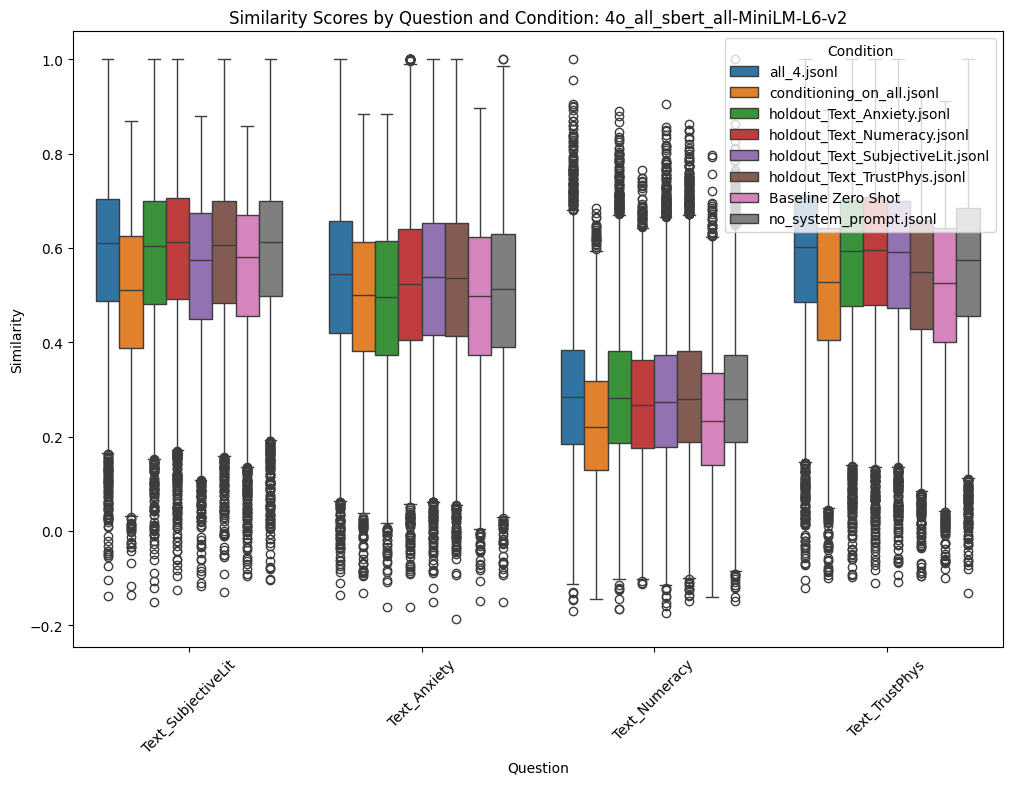

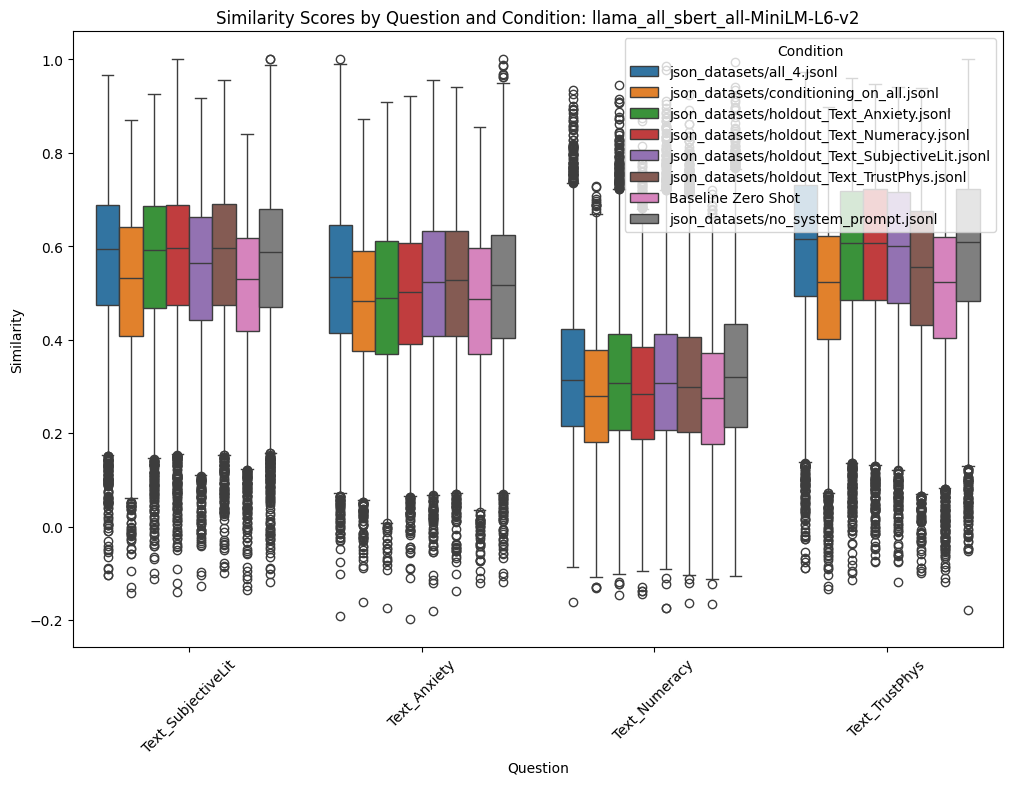

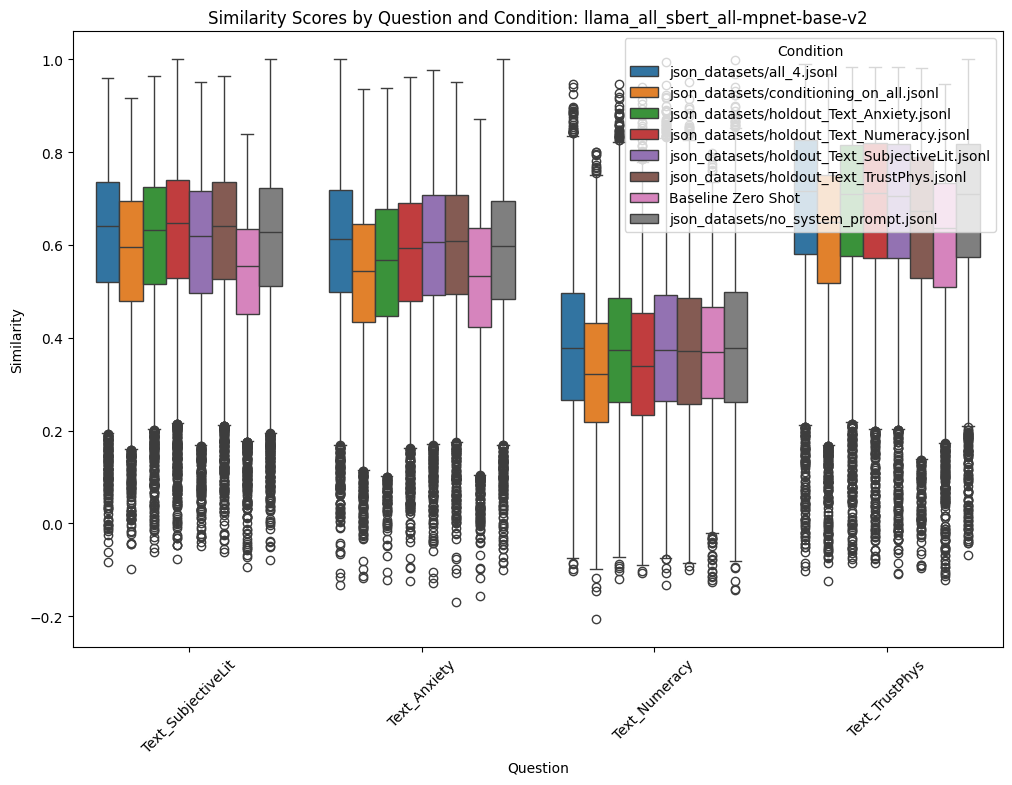

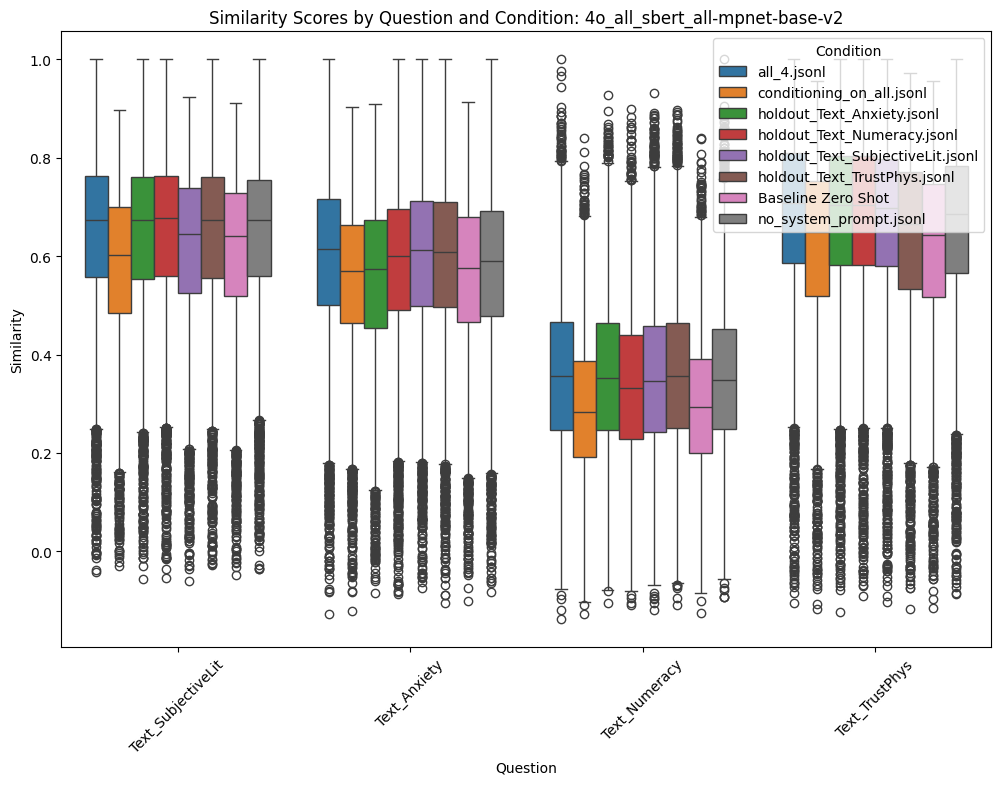

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


resultsFiles = ['4o_all_sbert_all-MiniLM-L6-v2',
 'llama_all_sbert_all-MiniLM-L6-v2',
 'llama_all_sbert_all-mpnet-base-v2',
 '4o_all_sbert_all-mpnet-base-v2']

for f in resultsFiles:
    data = pd.read_csv(f"similarity_calculations_{f}.csv")
    #data = similarity_df_bert_orig
    
    grouped_means = data.groupby(['Condition', 'Question'])['Similarity'].mean().reset_index()
    
    # Display the grouped means
    #print(grouped_means)
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Question', y='Similarity', hue='Condition', data=data)
    
    # Set the title and labels
    plt.title(f"Similarity Scores by Question and Condition: {f}")
    plt.xlabel('Question')
    plt.ylabel('Similarity')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', title='Condition')

    # save the plot
    plt.savefig(f"plots/figure1_{f}.png", bbox_inches='tight')

    # Show the plot
    #plt.show()


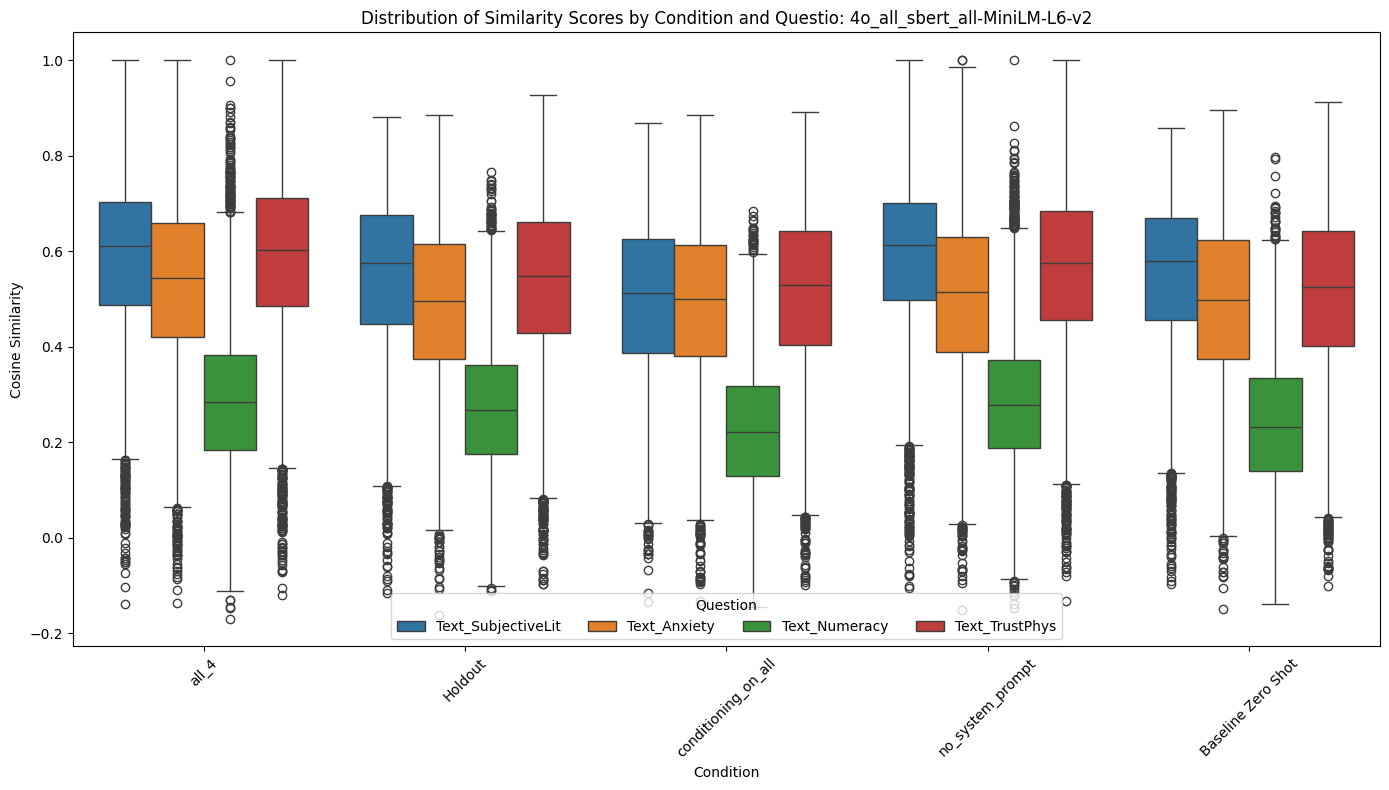

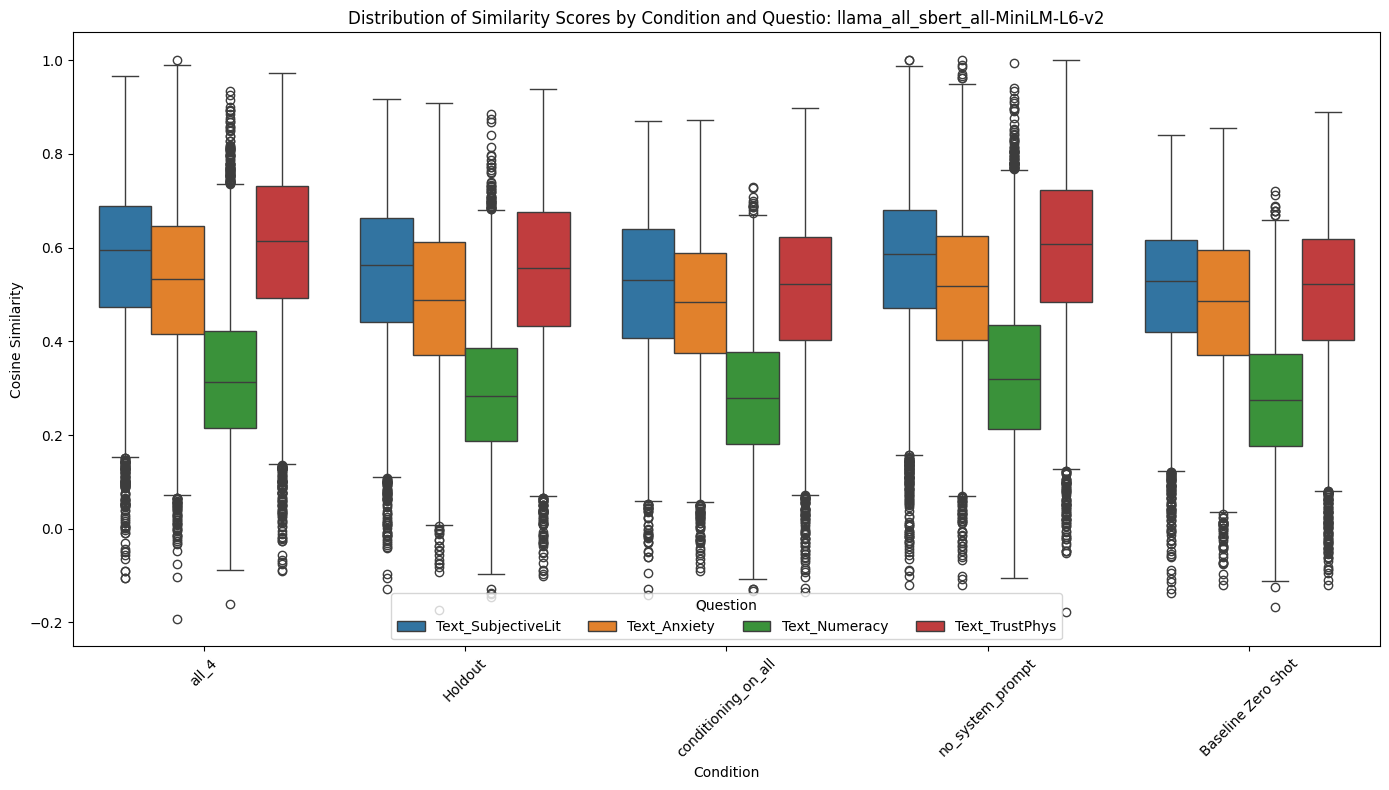

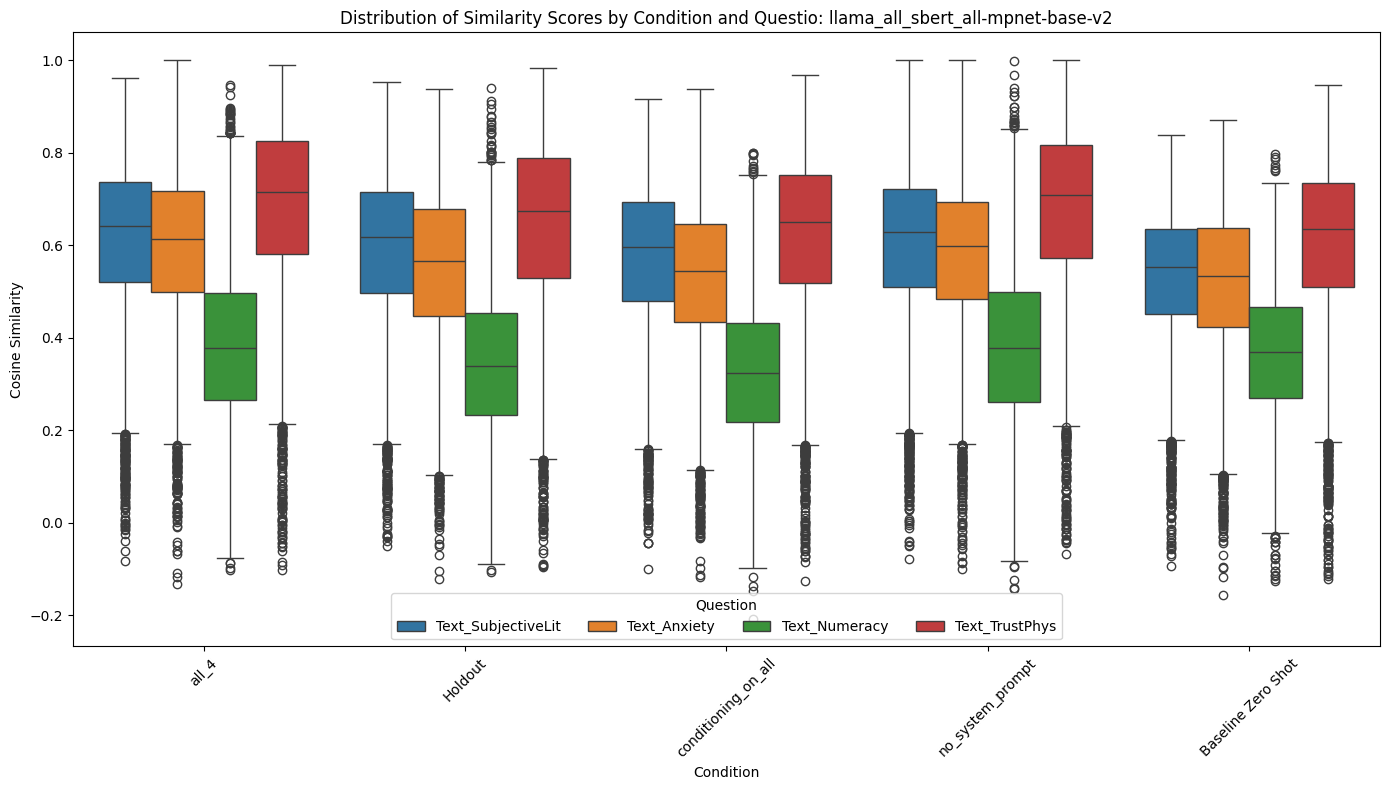

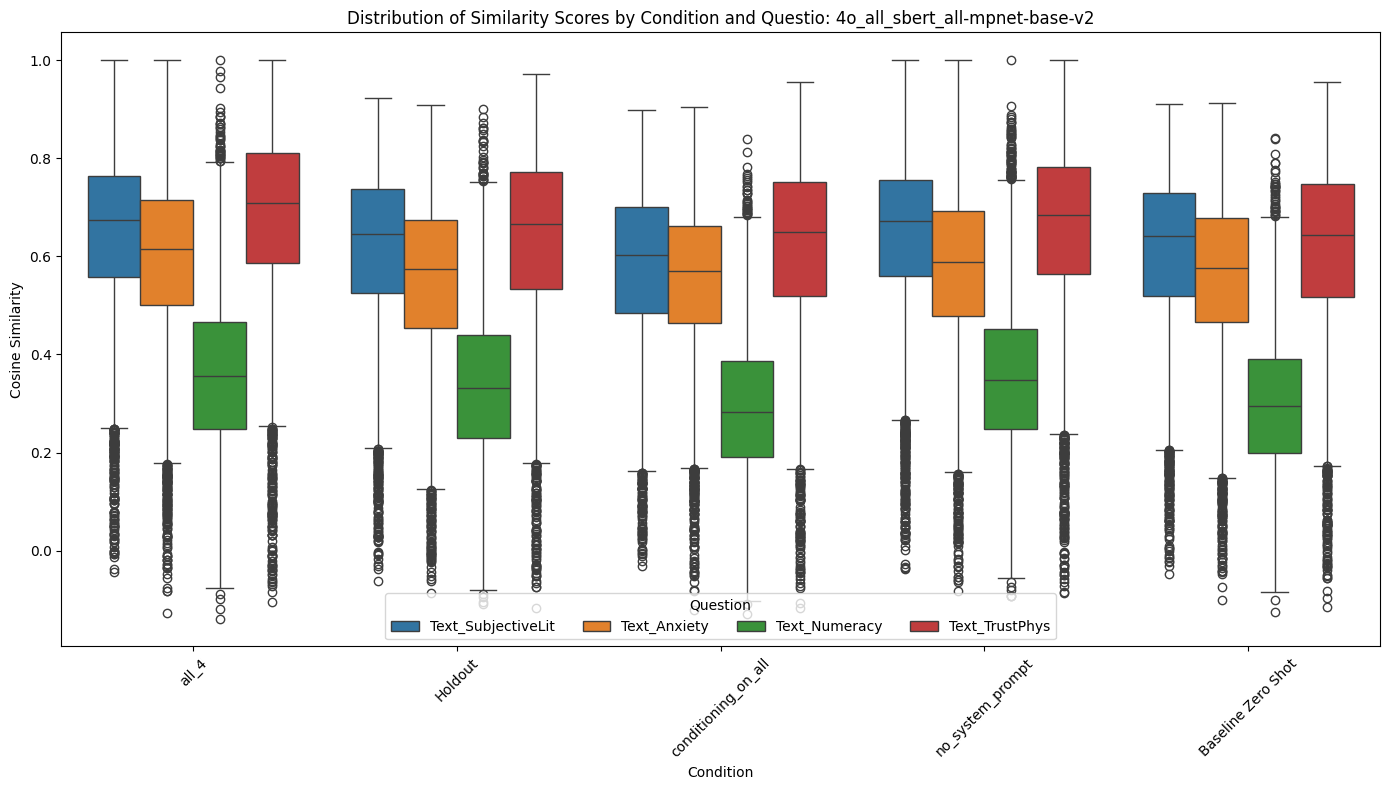

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_similarity_df(similarity_df):
    # Work on a copy of the DataFrame to preserve the original
    df_copy = similarity_df.copy()
    
    # Remove ".jsonl" from the Condition column, if present
    df_copy['Condition'] = df_copy['Condition'].str.replace('.jsonl', '')
    df_copy['Condition'] = df_copy['Condition'].str.replace('json_datasets/', '')

    #print(df_copy.head())


    # Define new order for 'Condition' column, adjusted for visualization
    # Define new order for 'Condition' column, adjusted for visualization
    condition_order = [
        'all_4', 'Holdout', 'conditioning_on_all','no_system_prompt','Baseline Zero Shot',
    ]


    # Handling specific holdout conditions
    holdout_conditions = {
        'holdout_Text_Anxiety': 'Text_Anxiety',
        'holdout_Text_Numeracy': 'Text_Numeracy',
        'holdout_Text_SubjectiveLit': 'Text_SubjectiveLit',
        'holdout_Text_TrustPhys': 'Text_TrustPhys'
    }

    # Initialize a DataFrame to store holdout data
    holdout_df = pd.DataFrame()

    # Filter out and rename specific holdout conditions
    for holdout, question in holdout_conditions.items():
        # Extract rows corresponding to each holdout condition
        specific_df = df_copy[df_copy['Condition'] == holdout]
        # Only keep rows that match the corresponding question
        specific_df = specific_df[specific_df['Question'] == question]
        specific_df['Condition'] = 'Holdout'  # Rename condition to 'Holdout'
        holdout_df = pd.concat([holdout_df, specific_df])

    df_copy = pd.concat([
        df_copy[~df_copy['Condition'].isin(holdout_conditions.keys())],
        holdout_df
    ])

    # Map the 'Condition' column to a categorical type with the specified order
    df_copy['Condition'] = pd.Categorical(
        df_copy['Condition'], categories=condition_order, ordered=True
    )

    return df_copy

def visualize_similarity(similarity_df, simConfig):
    df_processed = preprocess_similarity_df(similarity_df)
    # Boxplot visualization
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Condition', y='Similarity', hue='Question', data=df_processed)
    plt.title(f'Distribution of Similarity Scores by Condition and Questio: {simConfig}')
    plt.xlabel('Condition')
    plt.ylabel('Cosine Similarity')
    plt.xticks(rotation=45)
    plt.legend(
        title='Question',
        ncol=4,
        loc='lower center'
        #bbox_to_anchor=(1.02, 0.1), 
        #loc='upper left', 
        #borderaxespad=0
    )
    #plt.ylim(0.8, 1.0)
    #plt.legend(ncol=5)
    plt.tight_layout()
    # save the plot
    plt.savefig(f"plots/figure2_{simConfig}.png", bbox_inches='tight')

    #plt.show()

    # Violin plot visualization
    #sns.violinplot(x='Condition', y='Similarity', hue='Question', data=df_processed, split=True)
    #plt.title('Violin Plot of Similarity Scores')
    #plt.xlabel('Condition')
    #plt.ylabel('Cosine Similarity')
    #plt.xticks(rotation=45)
    #plt.legend(title='Question')
    #plt.tight_layout()
    #plt.show()

# Assuming similarity_df is your dataset

resultsFiles = ['4o_all_sbert_all-MiniLM-L6-v2',
 'llama_all_sbert_all-MiniLM-L6-v2',
 'llama_all_sbert_all-mpnet-base-v2',
 '4o_all_sbert_all-mpnet-base-v2']

for f in resultsFiles:
    data = pd.read_csv(f"similarity_calculations_{f}.csv")
    visualize_similarity(data, f)

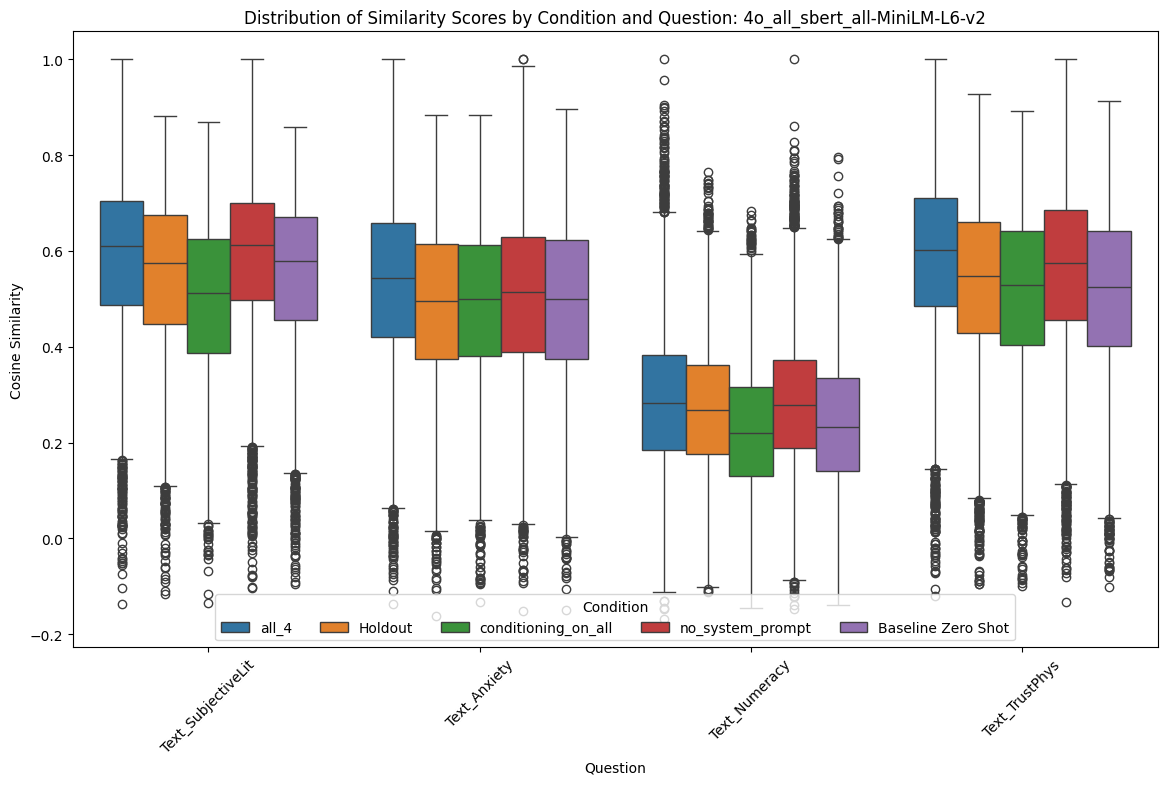

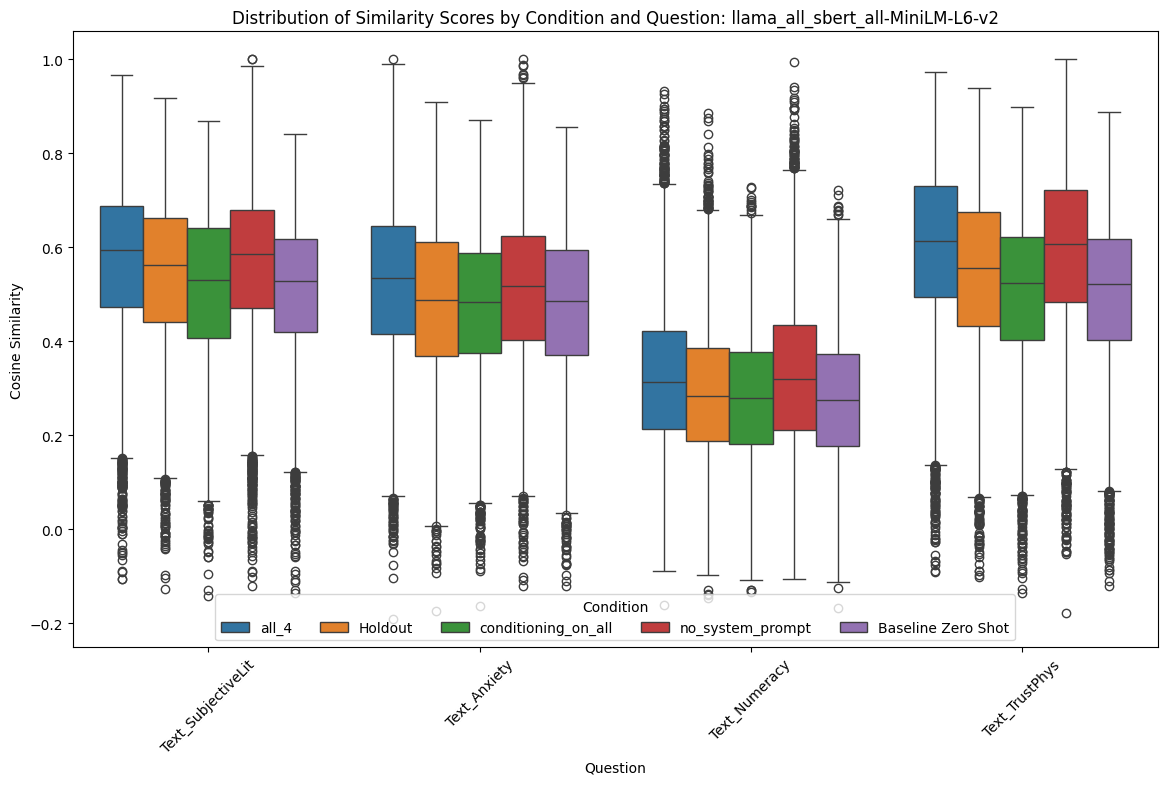

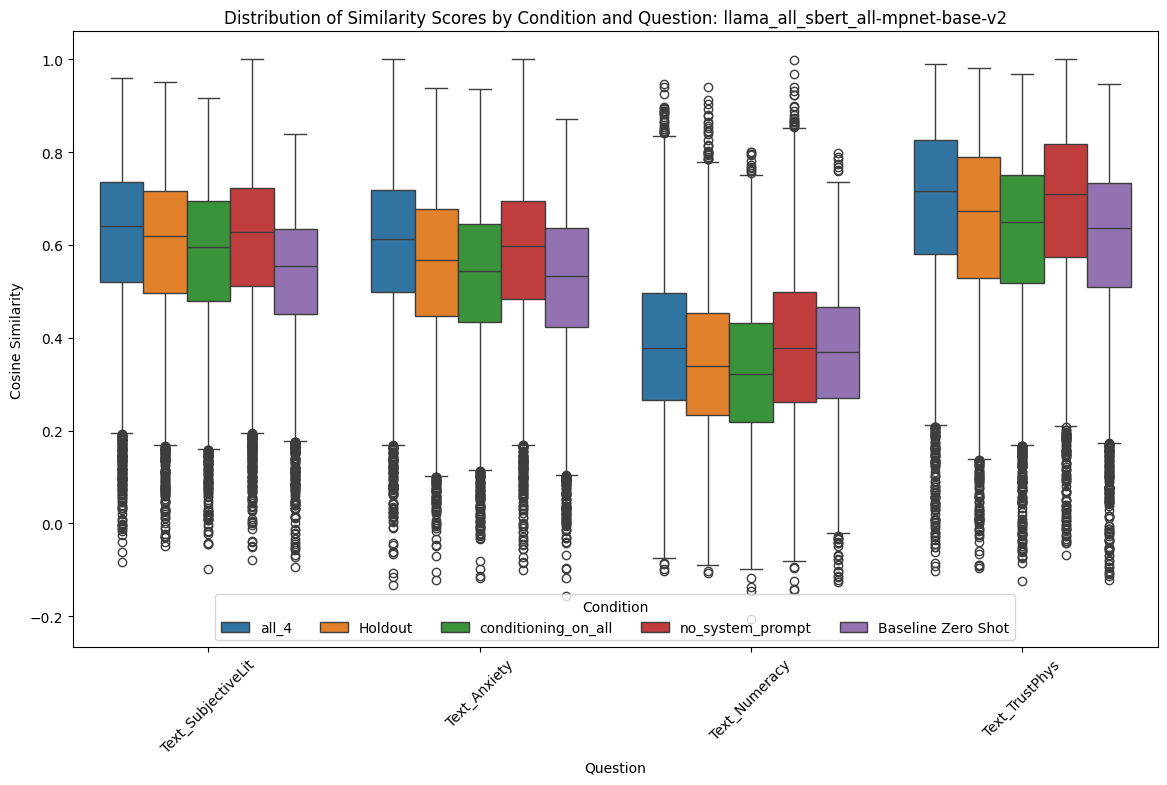

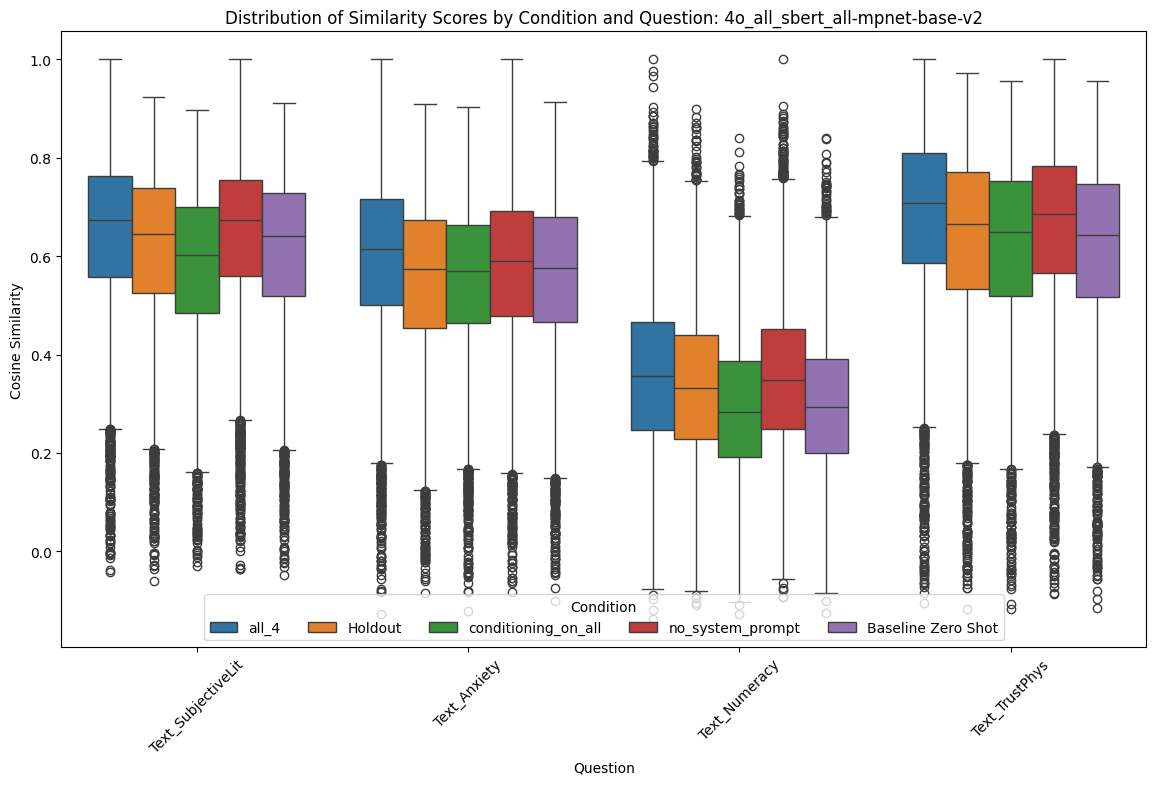

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_similarity_df(similarity_df):
    # Work on a copy of the DataFrame to preserve the original
    df_copy = similarity_df.copy()
    
    # Remove ".jsonl" from the Condition column, if present
    df_copy['Condition'] = df_copy['Condition'].str.replace('.jsonl', '')
    df_copy['Condition'] = df_copy['Condition'].str.replace('json_datasets/', '')

    #print(df_copy.head())


    # Define new order for 'Condition' column, adjusted for visualization
    # Define new order for 'Condition' column, adjusted for visualization
    condition_order = [
        'all_4', 'Holdout', 'conditioning_on_all','no_system_prompt','Baseline Zero Shot',
    ]


    # Handling specific holdout conditions
    holdout_conditions = {
        'holdout_Text_Anxiety': 'Text_Anxiety',
        'holdout_Text_Numeracy': 'Text_Numeracy',
        'holdout_Text_SubjectiveLit': 'Text_SubjectiveLit',
        'holdout_Text_TrustPhys': 'Text_TrustPhys'
    }

    # Initialize a DataFrame to store holdout data
    holdout_df = pd.DataFrame()

    # Filter out and rename specific holdout conditions
    for holdout, question in holdout_conditions.items():
        # Extract rows corresponding to each holdout condition
        specific_df = df_copy[df_copy['Condition'] == holdout]
        # Only keep rows that match the corresponding question
        specific_df = specific_df[specific_df['Question'] == question]
        specific_df['Condition'] = 'Holdout'  # Rename condition to 'Holdout'
        holdout_df = pd.concat([holdout_df, specific_df])

    df_copy = pd.concat([
        df_copy[~df_copy['Condition'].isin(holdout_conditions.keys())],
        holdout_df
    ])

    # Map the 'Condition' column to a categorical type with the specified order
    df_copy['Condition'] = pd.Categorical(
        df_copy['Condition'], categories=condition_order, ordered=True
    )

    return df_copy

def visualize_similarity(similarity_df, simConfig):
    df_processed = preprocess_similarity_df(similarity_df)
    # Boxplot visualization
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Question', y='Similarity', hue='Condition', data=df_processed)
    plt.title(f'Distribution of Similarity Scores by Condition and Question: {simConfig}')
    plt.xlabel('Question')
    plt.ylabel('Cosine Similarity')
    plt.xticks(rotation=45)
    #plt.legend(title='Condition')
    plt.legend(
        title='Condition',
        ncol=5,
        loc='lower center'
        #bbox_to_anchor=(1.02, 0.1), 
        #loc='upper left', 
        #borderaxespad=0
    )
    #plt.ylim(0.8, 1.0)
    # save the plot
    plt.savefig(f"plots/figure3_{simConfig}.png", bbox_inches='tight')

    #plt.tight_layout()
    #plt.show()

    # Violin plot visualization
    #sns.violinplot(x='Question', y='Similarity', hue='Condition', data=df_processed, split=True)
    #plt.title('Violin Plot of Similarity Scores')
    #plt.xlabel('Question')
    #plt.ylabel('Cosine Similarity')
    #plt.xticks(rotation=45)
    #plt.legend(title='Condition')
    #plt.tight_layout()
    #plt.show()

# Assuming similarity_df is your dataset

resultsFiles = ['4o_all_sbert_all-MiniLM-L6-v2',
 'llama_all_sbert_all-MiniLM-L6-v2',
 'llama_all_sbert_all-mpnet-base-v2',
 '4o_all_sbert_all-mpnet-base-v2']

for f in resultsFiles:
    data = pd.read_csv(f"similarity_calculations_{f}.csv")
    visualize_similarity(data, f)
    